In [1]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt 
import random 
import math
import cmath

In [2]:
#density functions

def gaussian(x):
    return np.exp(-0.5 * abs(x)**2)

def rect(x):
    if abs(x) > 1/2:
        return 0
    else:
        return 1
    
def strange_density(x):
    if abs(x) <= 0.08:
        return 0
    elif 0.08 <= abs(x) <= 0.16:
        return 500
    elif 0.16 <= abs(x) <= 0.32:
        return 10
    else:
        return 0 
    

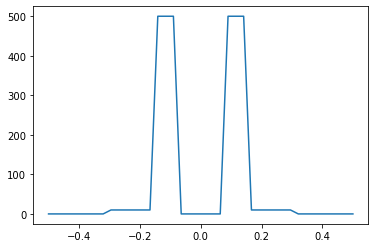

In [3]:
# draw strange_density
points = np.linspace(-0.5, 0.5, 40)
values = [strange_density(p) for p in points]
plt.plot(points, values)

In [4]:
def U(sp_density, M):
    W = [random.gauss(0, 1) for i in range(M)]
    U = []
    U.append(math.sqrt(sp_density(0))* W[0])
    for j in range(1, int(M/2)):
        u = complex(W[2*j-1], W[2*j])
        U.append(math.sqrt(0.5 * sp_density(j/M)) * u)
        
    U.append(math.sqrt(0.5 * sp_density(0.5)) * W[M-1])
    
    for j in range(int(M/2) + 1, M):
        U.append(np.conjugate(U[M-j]))
    return U         

In [5]:
def generate_GP(dense, M, number_of_functions):
    Uj = [U(dense, M) for i in range(number_of_functions)]
    Y = np.empty((number_of_functions, M))
    Y = [np.fft.fft(Uj[i])/np.sqrt(M) for i in range(number_of_functions)]
    for func in range(number_of_functions):
        Y[func] = [y.real for y in Y[func]]
    N = [i for i in range(M)]
    
    plt.figure(figsize=(15, 5), dpi=80)
    for func in range(number_of_functions):
        plt.plot(N, Y[func])
        
    plt.plot(N, np.zeros_like(N), color = 'green')     
    plt.show()  
    return Y

In [6]:
def built_density(kernel, M):
    """Builts 2 pictires:
       1. gaussian process according to a density function (kernel) given on the interval [0, M]. 
       2. density obtained by applying fft to the constructed process.
       Density is considered on interval [-0.5 , 0.5]
    """
    
    Y = generate_GP(kernel, M, 1)
    Q = np.fft.fft(Y[0])
    size = Q.shape[0]
    Q /= np.sqrt(size)
    N = [i/size for i in range(-size//2, size//2)]
    Q = np.hstack((Q[size//2:], Q[:size//2]))
    
    almost_density = np.log(np.abs(Q)**2 + 1e-20)
    true_density = [np.log(kernel(x)+1e-20) for x in N]
    
    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(N, almost_density)
    plt.plot(N, true_density)


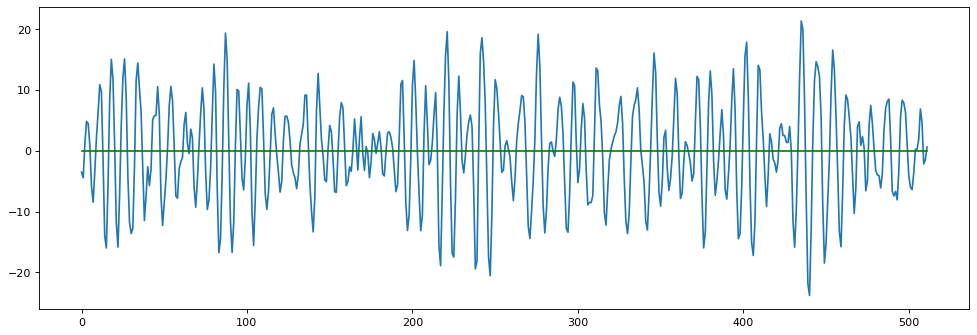

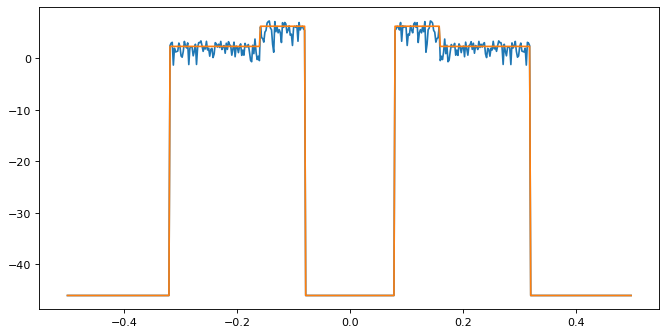

In [7]:
built_density(strange_density, 512)

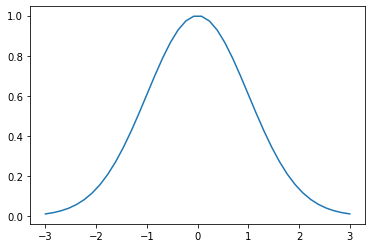

In [8]:
# draw gaussian density 
points = np.linspace(-3, 3, 40)
values = [gaussian(p) for p in points]
plt.plot(points, values)

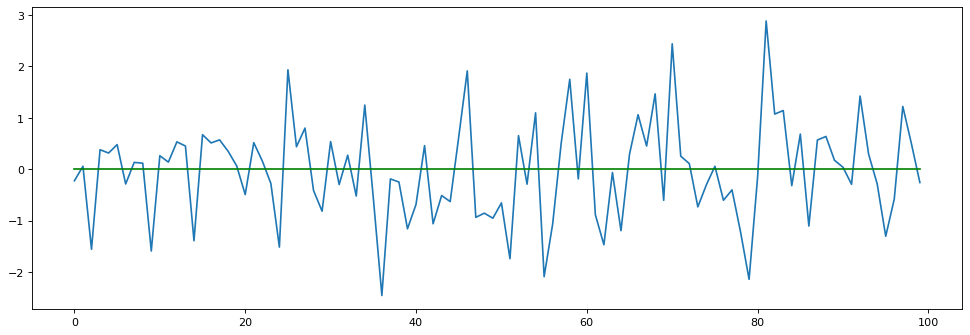

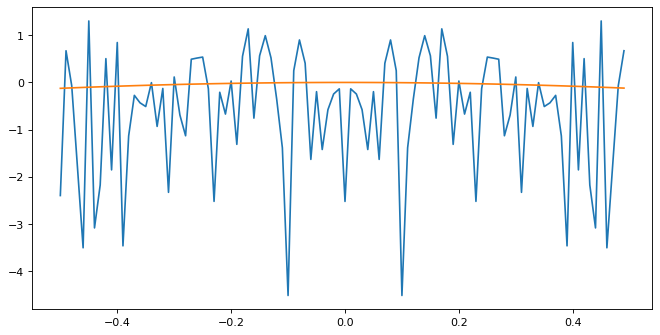

In [9]:
built_density(gaussian, 100)

# Solution 2 with scaling

In [10]:
def U_scale(sp_density, M, scale):
    W = [random.gauss(0, 1) for i in range(M)]
    U = []
    U.append(math.sqrt(sp_density(0))* W[0])
    for j in range(1, int(M/2)):
        u = complex(W[2*j-1], W[2*j])
        U.append(math.sqrt(0.5 * sp_density(scale*j/M)) * u)
    U.append(math.sqrt(0.5 * sp_density(scale*0.5)) * W[M-1])
    
    for j in range(int(M/2) + 1, M):
        U.append(np.conjugate(U[M-j]))
    return U    

In [11]:
def generate_GP_scale(dense, M, number_of_functions, scale):
    Uj = [U_scale(dense, M, scale) for i in range(number_of_functions)]
    Y = np.empty((number_of_functions, M))
    Y = [np.fft.fft(Uj[i])/np.sqrt(M) for i in range(number_of_functions)]
    for func in range(number_of_functions):
        Y[func] = [y.real for y in Y[func]]
    N = [i for i in range(M)]
    
    fig = plt.figure(figsize=(15, 5), dpi=80)
    for func in range(number_of_functions):
        plt.plot(N, Y[func])
        
    plt.plot(N, np.zeros_like(N), color='green')    
    plt.show() 
    return Y

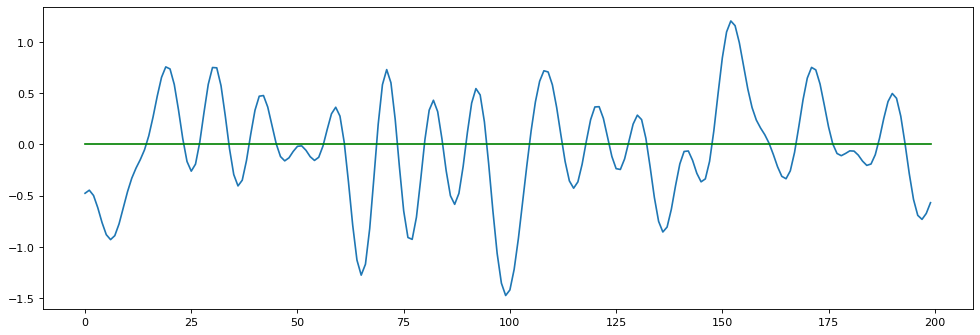

In [12]:
a = generate_GP_scale(rect, 200, 1, 5)

In [13]:
def built_density_scale(kernel, M, scale):
    """Builts 2 pictires:
       1. gaussian process according to a density function (kernel) given on the interval [0, M]. 
       2. density obtained by applying fft to the constructed process.
       Density is considered on interval [-scale , scale]
    """
    built_density(lambda x: kernel(x*scale), M)


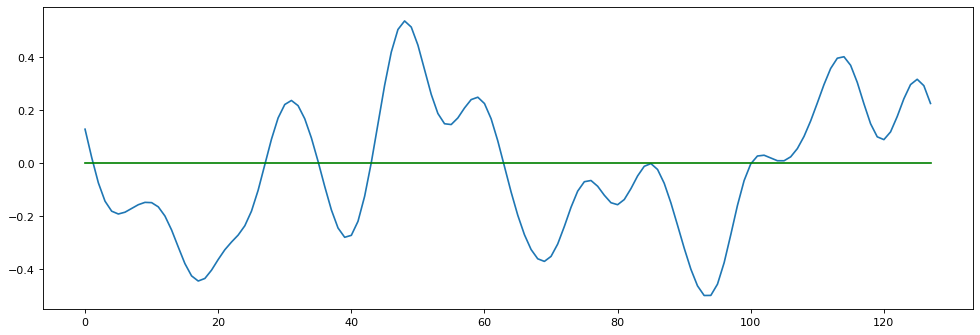

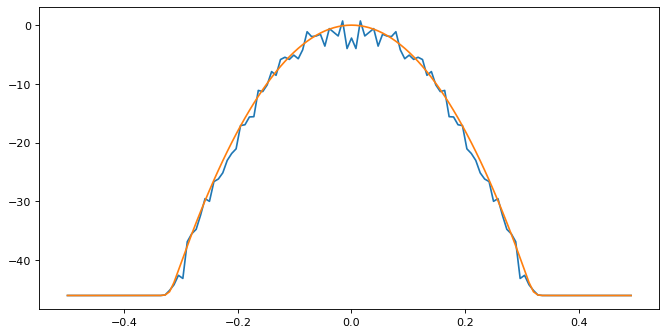

In [14]:
built_density_scale(gaussian, 128, 30)

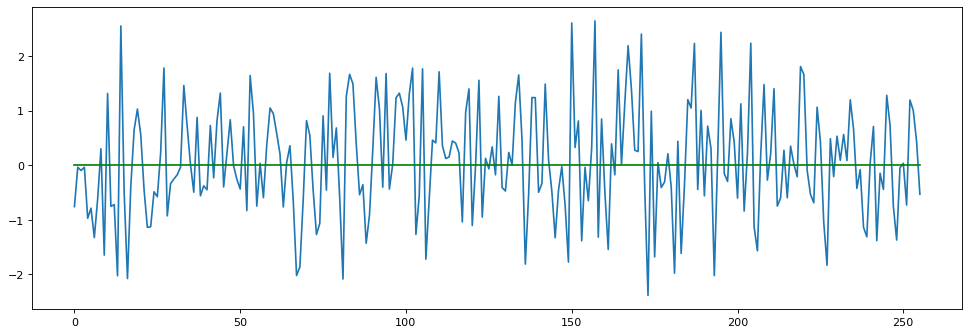

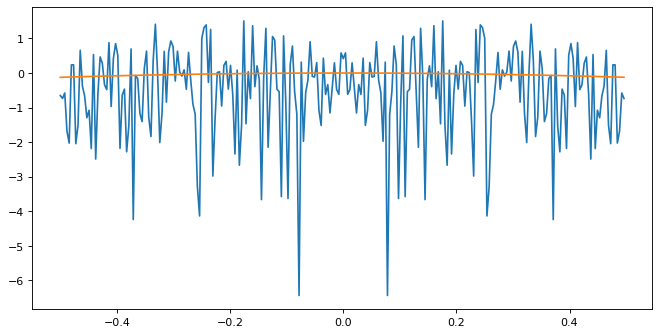

In [15]:
built_density_scale(gaussian, 256, 1)

In [16]:
def cmp(a, b):
    if a > b:
        return 1
    elif a < b:
        return -1
    else:
        return 0

In [17]:
def integral(kernel):
    points = list(np.linspace(-7, 7, 701)) # divide [-7, 7] onto 700 segments. 
    points.pop(-1) # will use values in the middle of each segment, so need to erase last point
    res = 0
    for point in points:
        res += kernel(point+0.01)*0.02 # point+0.01 -- the middle of segment. 0.02 -- length of segment
    return res

def prime_prime(kernel):
    f = lambda x: x* x * kernel(x)
    return -integral(f)

In [18]:
print(integral(rect))
print(prime_prime(rect))


1.0000000000000004
-0.08330000000000001


In [19]:
def intersections(kernel, M, number_of_functions, scale):
    zeros = np.zeros(number_of_functions)
    Y = np.array(generate_GP_scale(kernel, M, number_of_functions, scale))
    size = Y.shape[1]
    for j in range(number_of_functions):
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0):
                zeros[j] += 1
    f = lambda x: kernel(x)*rect(x)            
    deriv = -prime_prime(f) # -вторая производная
    alfa = 2*np.pi* np.sqrt(deriv/(integral(f) + 10e-8)) /scale
    E_zeros = 1/np.pi * alfa * M # считаю среднее число нулей по формуле
    
    # и округляю до ближайшего целого 
    if np.ceil(E_zeros) - E_zeros > E_zeros - np.floor(E_zeros): 
        E_zeros = np.floor(E_zeros)
    else:
        E_zeros = np.ceil(E_zeros)
        
    plt.figure(figsize = (10, 5), dpi=80)
    plt.hist(zeros, edgecolor='white')
    print("E_zeros:", E_zeros)    
    return zeros , E_zeros


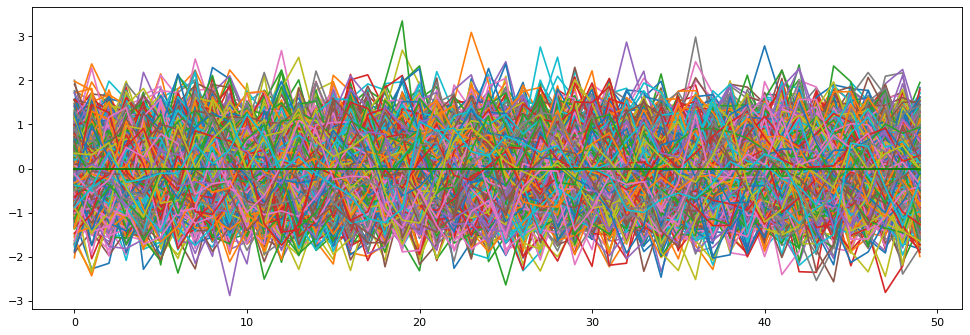

E_zeros: 6.0


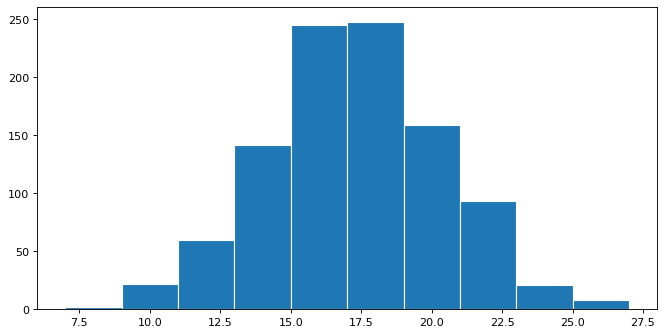

In [20]:
a = intersections(gaussian, 50, 1000, 5)

 # New solution 

In [21]:
# scale is a cut-off frequency for spectral density, i.e. maximum LINEAR frequency of discrete signal
def GP(density, delta, M, scale, number_of_points, number_of_functions = 1, ls = True):
    N = int(scale/delta)
    x_density = np.linspace(0, scale, N+1) # 2*pi*x_density[k] = omega_k from paper
    coeff = np.sqrt([2*density(x)*delta for x in x_density])
    
    points = np.linspace(0, M, number_of_points)
    X = np.zeros((number_of_functions, number_of_points))
    plt.figure(figsize=(15, 5), dpi=80)
    for func in range(number_of_functions):
        W = [random.gauss(0,1) for i in range(2*N + 2)]

        for i, point in enumerate(points):
            for j in range(N+1):
                X[func, i] += coeff[j] * (np.sin(x_density[j]*point*2*np.pi) * W[j] + np.cos(x_density[j]*point*2*np.pi) * W[j+N])
        if ls:
            plt.plot(points, X[func])
    if ls:    
        plt.plot(points, np.zeros_like(points), color='green')    
        plt.show()
    return X

In [22]:
def unit(x):
    return 1

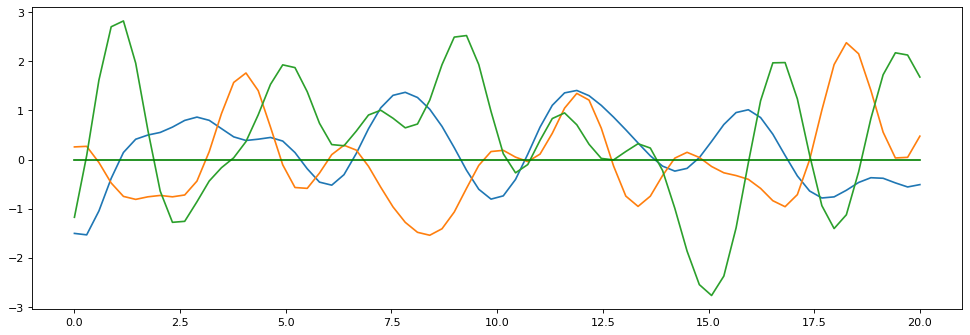

In [32]:
a = GP(rect, 0.01, 20, 5, 70, 3)

In [34]:
def new_built_density(kernel, delta, M, scale, ls = True):
    """Builts 2 pictires:
       1. gaussian process according to a density function (kernel) given on the interval [0, M]. 
       2. density obtained by applying fft to the constructed process.
       Density is considered on interval [-0.5 , 0.5]
    """
    Y = GP(kernel, delta, M, scale, int(M*2*scale +1), 1, ls)[0]
    Q = np.fft.fft(Y)
    size = Q.shape[0]
    Q /= np.sqrt(size) 
    N = [i*scale*2/size for i in range(-size//2, size//2)]
    Q = np.hstack((Q[size//2:], Q[:size//2]))
    
    almost_density = np.abs(Q)**2
    true_density = [kernel(x) for x in N]

    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(N, almost_density)
    plt.plot(N, true_density)


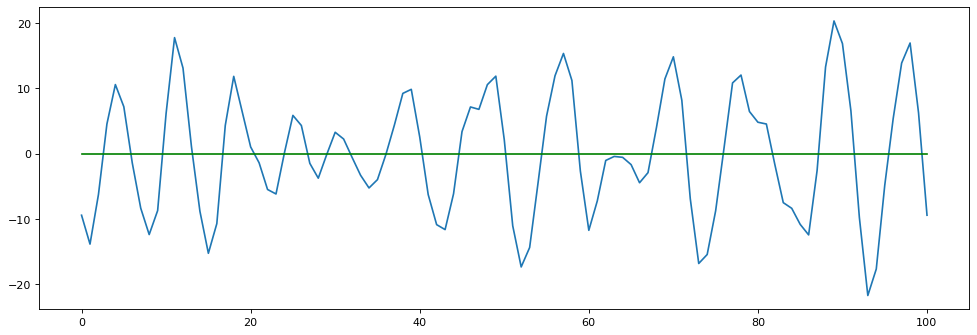

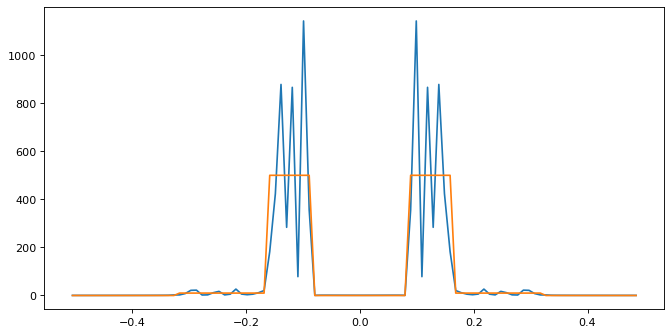

In [35]:
new_built_density(strange_density, 0.01, 100, 0.5)

In [26]:
def new_intersections(kernel, delta, M, number_of_functions, number_of_points, scale, ls = True):
    zeros = np.zeros(number_of_functions)
    Y = np.array(GP(kernel, delta, M, scale, number_of_points, number_of_functions, ls))
    size = Y.shape[1]
    for j in range(number_of_functions):
        pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]
        for (a,b) in pairs:
            if cmp(a, 0) != cmp(b, 0):
                zeros[j] += 1
                
    deriv = -prime_prime(kernel) # minus secon derivative
    alfa = np.sqrt(deriv/(integral(kernel) + 10e-8)) * 2 * np.pi
    E_zeros = 1/np.pi * alfa * M # count average amount of zeros using Kac-Rice formula
    
    # round to nearest integer 
    if np.ceil(E_zeros) - E_zeros > E_zeros - np.floor(E_zeros): 
        E_zeros = np.floor(E_zeros)
    else:
        E_zeros = np.ceil(E_zeros)
    
    plt.figure(figsize = (10, 5), dpi=80)
    plt.hist(zeros, edgecolor='white')
    print("E_zeros:", E_zeros)
    return zeros , E_zeros

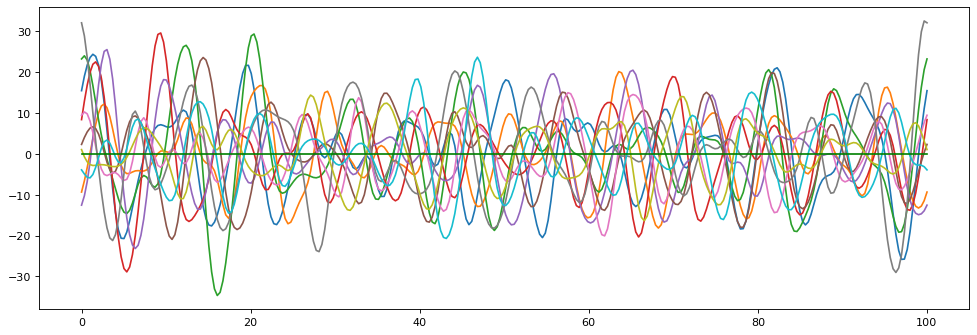

E_zeros: 26.0


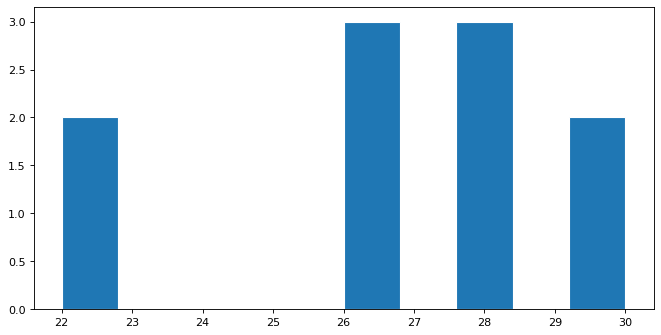

In [ ]:
                      #kernel, delta, M, funct,points,scale   
a = new_intersections(strange_density, 0.01, 100, 10, 300, 10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\nasty\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-297214b03123>", line 11, in <module>
    zeros, E_zeros = new_intersections(kernel[j], 0.01, t, 1000, 300, 7)
  File "<ipython-input-26-df443d947fe3>", line 3, in new_intersections
    Y = np.array(GP(kernel, delta, M, scale, number_of_points, number_of_functions, ls))
  File "<ipython-input-21-cab35b7fbbd5>", line 15, in GP
    X[func, i] += coeff[j] * (np.sin(x_density[j]*point*2*np.pi) * W[j] + np.cos(x_density[j]*point*2*np.pi) * W[j+N])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\nasty\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attrib

TypeError: object of type 'NoneType' has no len()

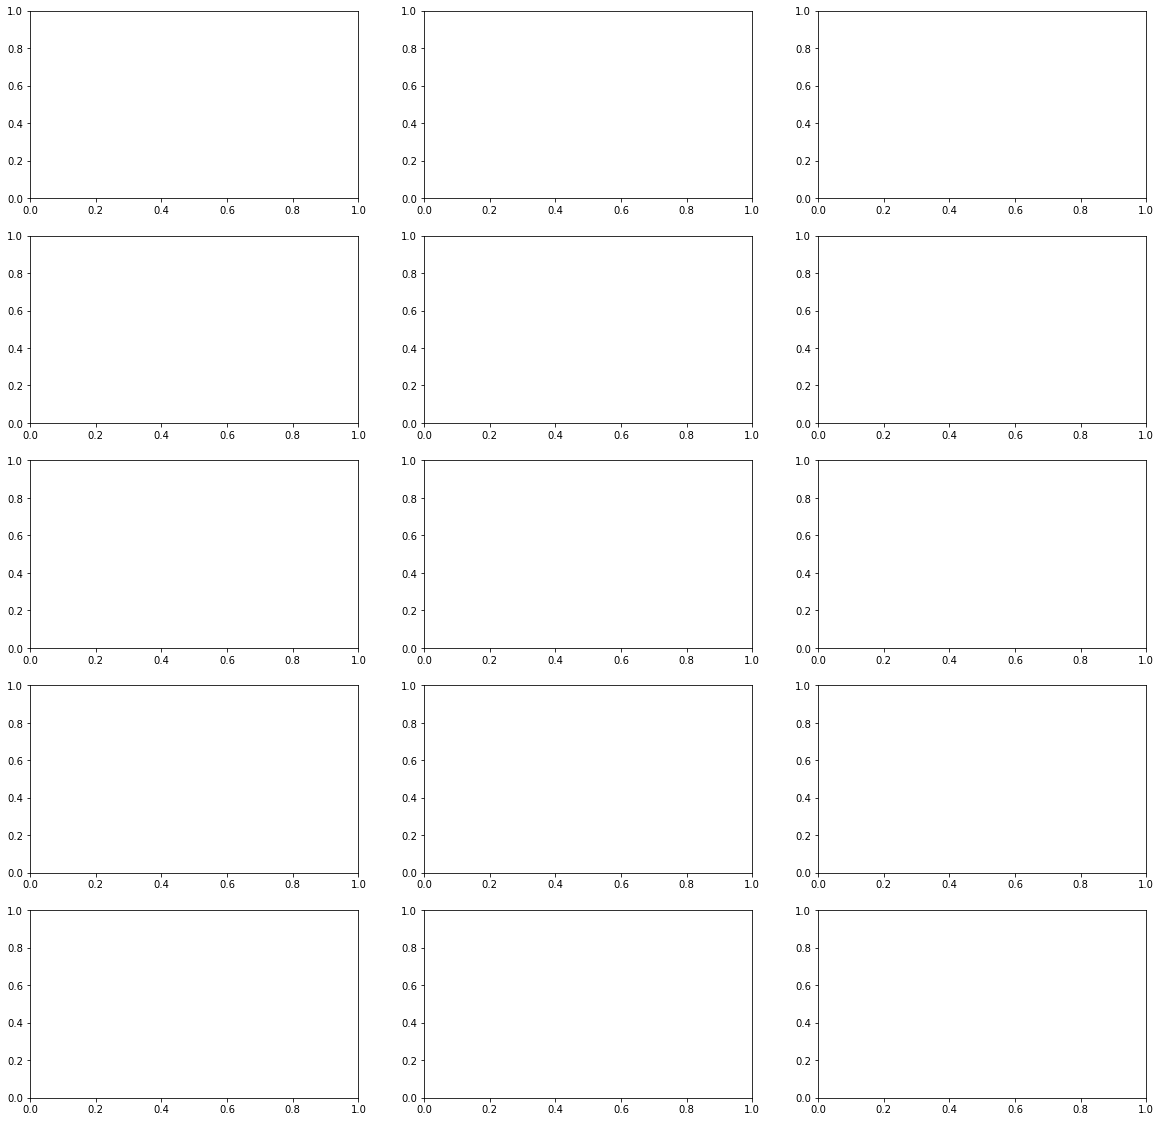

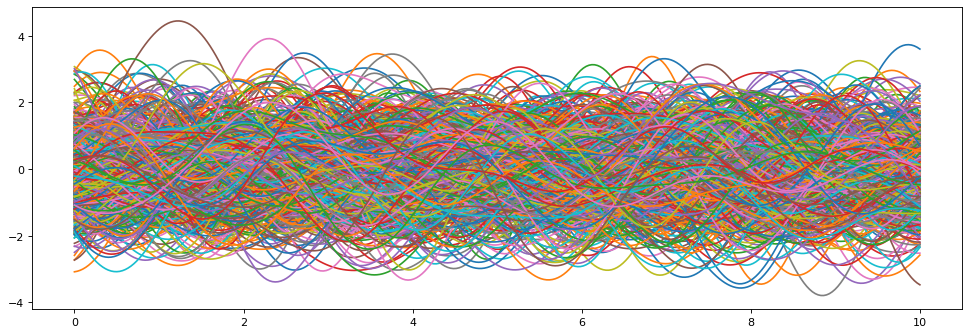

In [28]:
Eps = [1, 2, 3, 4, 5] # epsilon
kernel = [rect, gaussian, strange_density] # density functions
kernel_names = ["rect", "gaussian", "strange"]
T = [n for n in range(10, 20)] # time intervals 

fig, axs = plt.subplots(len(Eps), len(kernel), figsize=(20, 20))
for i in range(len(Eps)):
    for j in range(len(kernel)):
        P = np.zeros(len(T))
        for idx, t in enumerate(T):      #kernel, delta, M, funct,points,scale   
            zeros, E_zeros = new_intersections(kernel[j], 0.01, t, 1000, 300, 7) 
            cnt = 0
            for k in range(len(zeros)):
                if zeros[k]/t - E_zeros/t > Eps[i]/t:
                    P[idx] += 1
        P += 10e-30            
        P = np.log(P/1000)
        axs[i, j].plot(T, P/t)
        axs[i, j].set_title(f'{Eps[i]},{kernel_names[j]}')

In [31]:
T = [n for n in range(1010, 1040)] # time intervals
P = np.zeros(len(T))
for idx, t in enumerate(T):      #kernel, delta, M, funct,points,scale   
    zeros, E_zeros = new_intersections(rect, 0.02, t, 100, 3*t, 1/2, ls = False) 
    cnt = 0
    for k in range(len(zeros)):
        if zeros[k]/t - E_zeros/t > 5/t:
            P[idx] += 1
P += 10e-30            
P = np.log(P/100)
plt.plot(T, -P/t)

<ipython-input-21-cab35b7fbbd5>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 5), dpi=80)


KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [36]:
number_of_functions = 100
kernel = rect
number_of_points = 600
M = 200
scale = 5
delta = 0.001

zeros = np.zeros(number_of_functions)                         
Y = np.array(GP(kernel, delta, M, scale, number_of_points, number_of_functions, ls = False))
size = Y.shape[1]
for j in range(number_of_functions):
    pairs = [(Y[j][i], Y[j][i+1]) for i in range(size - 1)]
    for (a,b) in pairs:
        if cmp(a, 0) != cmp(b, 0):
            zeros[j] += 1
                
deriv = -prime_prime(kernel) # minus secon derivative
alfa = np.sqrt(deriv/(integral(kernel) + 10e-8)) * 2 * np.pi
E_zeros = 1/np.pi * alfa * M # count average amount of zeros using Kac-Rice formula
    
# round to nearest integer 
if np.ceil(E_zeros) - E_zeros > E_zeros - np.floor(E_zeros): 
    E_zeros = np.floor(E_zeros)
else:
    E_zeros = np.ceil(E_zeros)    
print(E_zeros)

X = np.linspace(0, M, number_of_points)  
null = np.zeros_like(X)


for i in range(number_of_functions):
    if zeros[i] - E_zeros < - 20:
        plt.plot(X, Y[i])
        plt.plot(X, null)
        Q = np.fft.fft(Y[i])
        size = Q.shape[0]
        Q /= np.sqrt(size) 
        N = [i*scale*2/size for i in range(-size//2, size//2)]
        Q = np.hstack((Q[size//2:], Q[:size//2]))
        almost_density = np.abs(Q)**2 
        true_density = [kernel(x) for x in N]

        plt.figure(figsize=(10, 5), dpi=80)
        plt.plot(N, almost_density)
        plt.plot(N, true_density)

        break 
        

new_built_density(kernel, delta, M, scale)

KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>